In [1]:
#before anything else, lets get a time series. In our case, we will get the volume-time plot of one of the recording.
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy.io import wavfile # package to read WAV file
import pandas as pd
sns.set_style("white")
sns.set_style("ticks")
import warnings
warnings.filterwarnings("ignore")
import latexify as lt

import matplotlib.pyplot as plt # matplot lib is the premiere plotting lib for Python: https://matplotlib.org/
import numpy as np # numpy is the premiere signal handling library for Python: http://www.numpy.org/
import scipy as sp # for signal processing
from scipy import signal
from scipy.io import wavfile
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
#from IPython.display import Audio


#for filter
from scipy.signal import butter
from scipy.signal import lfilter
from scipy.signal import freqz;

In [2]:
from sklearn.decomposition import PCA
from kats.consts import TimeSeriesData
from statsmodels.tsa.seasonal import STL
from kats.utils.simulator import Simulator
from sklearn.preprocessing import StandardScaler
from kats.tsfeatures.tsfeatures import TsFeatures
from datetime import datetime, timedelta

import warnings
warnings.simplefilter(action='ignore')

In [3]:
def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2

    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes);

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='highpass', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y;

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


In [8]:
import os
mypath="clothdata/"
(_, _, filenames) = next(os.walk(mypath))

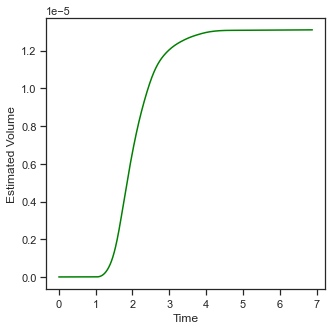

In [9]:
# minimal code to get volume time plot
fileList=[]
for file in filenames:
    fs = 16000
    #print("Reading:", file)
    fileList.append(file)
    fig, ax = plt.subplots(1,1,figsize=(5,5))
    x = pd.read_json(mypath+file, orient='keys')['payload']['values']
    x = x/np.max(np.abs(x))
    t = np.arange(0,len(x))/fs
    #filter the signal and show it
     #FILTEING THE SIGNAL
    cutoff_low = 1000 # desired cutoff frequency of the filter, Hz
    cutoff_high = 3500
    order = 15
    
    #x_filt = butter_highpass_filter(x, cutoff, fs, order)
    x_filt = butter_bandpass_filter(x,cutoff_low,cutoff_high,fs,order)
    
    #get analytic signal
    x_filt_hilbert = signal.hilbert(x_filt)
    envelope_hat = np.abs(x_filt_hilbert)
    #filter the Hilbert envelope
    nyq_rate = fs /0.5
    width = 1.0/nyq_rate # 5 Hz filter transition width.
    ripple_db = 10.0 # stop band attenuation
    fL_hz = 10
    N, beta = signal.kaiserord(ripple_db, width)
    taps = signal.firwin(N, fL_hz/nyq_rate, window=('kaiser', beta))
    envelope_hat_filt = signal.filtfilt(taps, 1,envelope_hat)
    
    #get the starting point of exhalation heuristically
    indexOflargestNegative = np.where(envelope_hat_filt == envelope_hat_filt.min())[0][0]
    indexOfExhalationStart = np.where((envelope_hat_filt[indexOflargestNegative:]>0) == True)[0][0]+indexOflargestNegative
    envelope_hat_filt = envelope_hat_filt[indexOfExhalationStart:]
    #we may have to attend 1 second of 0s to the envelope arrray
    envelope_hat_filt = np.insert(envelope_hat_filt, 0, np.zeros(fs))
    #get the new time
    t = np.arange(0,len(envelope_hat_filt))/fs
    
    envelope_hat_filt_normalized = envelope_hat_filt/np.sum(envelope_hat_filt)
    #Corresponds to PEF
    envelope_hat_filt_normalized = envelope_hat_filt/np.sum(envelope_hat_filt)
    
    
    #take cumsum of flow and then normalize
    estdVolume = np.cumsum(envelope_hat_filt)
    estdVolume = estdVolume/np.sum(estdVolume)
    ax.plot(t,estdVolume,color='green',label='Estimated Volume')
    ax.set_ylabel('Estimated Volume')
    ax.set_xlabel('Time')
    
    break;


In [22]:
ts = pd.DataFrame({'time':t, 'value':estdVolume})
ts = ts[::8] #becuase we dont have enough RAM, so cutting down data points

In [25]:
# Step 1. initiate TsFeatures
model = TsFeatures()

# Step 2. use .transform() method, and apply on the target time series data
output_features = model.transform(ts)
output_features

{'length': 13766,
 'mean': 9.080164324095334e-06,
 'var': 2.875529971680188e-11,
 'entropy': 0.1282638158137818,
 'lumpiness': 7.837537395364504e-32,
 'stability': 2.874243297955219e-11,
 'flat_spots': 1376,
 'hurst': 1.000249761081711,
 'std1st_der': 1.6532525658225821e-09,
 'crossing_points': 1,
 'binarize_mean': 0.6678773790498329,
 'unitroot_kpss': 152.9834903415424,
 'heterogeneity': 13755.999999889029,
 'histogram_mode': 1.1797987887872836e-05,
 'linearity': 0.7564839121801361,
 'trend_strength': 0.999999999998692,
 'seasonality_strength': 0.00012855694029056952,
 'spikiness': 5.776369456225042e-53,
 'peak': 0,
 'trough': 0,
 'level_shift_idx': 3503,
 'level_shift_size': 5.947684801736153e-09,
 'y_acf1': 0.9998752922323193,
 'y_acf5': 4.996254562503544,
 'diff1y_acf1': 0.9999754035789098,
 'diff1y_acf5': 4.999218059276906,
 'diff2y_acf1': 0.9999952963841827,
 'diff2y_acf5': 4.999608274405732,
 'y_pacf5': 0.9999027534014046,
 'diff1y_pacf5': 1.000636616319169,
 'diff2y_pacf5': 1.0